# Adaptive filtering Demo

In this Jupyter notebook you will find all the tools regarding our different implementations of adaptive filtering algorithms. 
In order, you can try:
- LMS
- NLMS
- Momentum
- Signed 
- RLS
- Fast Block
- AP

In [55]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
from scipy.io import wavfile
import librosa  
from sklearn.metrics import mean_squared_error
import pyaudio
import wave
import sys
import soundfile
import math

First we prepare our demo: you can replace "bassLineTalkingNoise.wav" by your own noisy signal, and "talkingNoise.wav" by the noise that is present in your noisy signal.

sampling rate: 8000 Hz, data length: 134671 samples


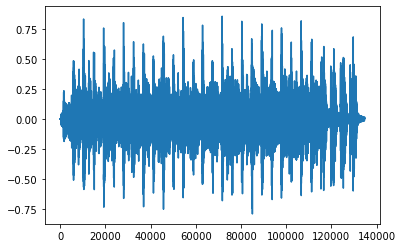

In [56]:
s, Fs = librosa.load("groove.wav", sr=8000)
print('sampling rate:', Fs, 'Hz, data length:', len(s), 'samples')
plt.plot(s)

In [57]:
IPython.display.Audio(s, rate=Fs)

sampling rate: 8000 Hz, data length: 134671 samples
sampling rate: 8000 Hz, data length: 134671 samples
sampling rate: 8000 Hz, data length: 134671 samples
sampling rate: 8000 Hz, data length: 134671 samples


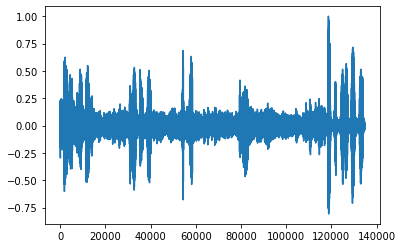

In [58]:
# Choose any wave file as Signal Y (Noisy if simulated=False or Clear if simulated=True)
sY, FsY = librosa.load('bassLineTalkingNoise.wav', sr=8000) # Downsample 44.1kHz to 8kHz #WHY
sY = sY[:len(s)]
print('sampling rate:', FsY, 'Hz, data length:', len(sY), 'samples')

# Choose a wave file as Noise X
sX, FsX = librosa.load('talkingNoise.wav', sr=8000) # Downsample 44.1kHz to 8kHz
sX = sX[:len(s)]
print('sampling rate:', FsX, 'Hz, data length:', len(sX), 'samples')


h_len = 5
h = np.random.normal(h_len)
noise = np.convolve(sX, h)
noise = noise/np.max(noise)
plt.plot(noise)

print('sampling rate:', FsX, 'Hz, data length:', len(noise), 'samples')
sY = s+noise
print('sampling rate:', FsY, 'Hz, data length:', len(sY), 'samples')

sY = sY[:min(len(sY),len(sX))] #not necessary


Below you can find the noisy audio that we used in the demo, and then only the noise. 

In [59]:
IPython.display.Audio(sY, rate=FsX)

In [60]:
IPython.display.Audio(sX, rate=FsX)

# Filtering algorithms

In [61]:
def lms_live(x, d, N, a, Nit, w, parameters):
    eps = parameters
    # number of iterations
    L = min(len(x), len(d))
    
    e = np.zeros(L)
    
    # run the adaptation
    for n in range(N-1, L):
        
        X = x[n-N+1:n+1]
        
        for j in range(Nit):
            w = w + a * X * (d[n] - np.dot(X.T, w))  
            
        # estimate output and error
        e[n] = d[n] - np.dot(w.transpose(), X) 
        
    return e[N:], w

In [62]:
def nlms_live(x, d, N, a, Nit, w, parameters):
    # Run the NLMS adaptation and returns filtered data with the updated parameters to be reused for real time filtering
    eps = parameters
    # number of iterations
    L = min(len(x), len(d))
    
    e = np.zeros(L)
    
    # run the adaptation
    for n in range(N-1, L):
        
        X = x[n-N+1:n+1]
        muNorm = a/(eps+np.linalg.norm(X)**2)
        
        for j in range(Nit):
            w = w + muNorm * X * (d[n] - np.dot(X.T, w))  
            
        # estimate output and error
        e[n] = d[n] - np.dot(w.transpose(), X) 
        
    return e[N:], w

In [63]:
def momentum_live(x, d, N, a, Nit, w, parameters):
    w_prev, beta = parameters
    # number of iterations
    L = min(len(x), len(d))
    
    e = np.zeros(L)
    
    # run the adaptation
    for n in range(N-1, L):
        
        X = x[n-N+1:n+1]
        
        for j in range(Nit):
            w = w + a * X * (d[n] - np.dot(X.T, w))  + beta * (w_prev[0] - w_prev[1])
            
        # estimate output and error
        e[n] = d[n] - np.dot(w.transpose(), X) 
        
    return e[N:], w

In [64]:
def signsign_live(x, d, N, a, Nit, w, parameters):
    a = 0.000001
    # number of iterations
    L = min(len(x), len(d))
    
    e = np.zeros(L)
    
    # run the adaptation
    for n in range(N-1, L):
        
        X = x[n-N+1:n+1]
        
        for j in range(Nit):
            w = w + a * np.sign(X) * np.sign(d[n] - np.dot(X.T, w))  
            
        # estimate output and error
        e[n] = d[n] - np.dot(w.transpose(), X) 
        
    return e[N:], w

In [65]:
def rls_live(x, d, N, a, Nit, w, R):
    # Run the RLS adaptation and returns filtered data with the updated parameters to be reused for real time filtering
    
    # number of iterations
    L = min(len(x), len(d))
    
    e = np.zeros(L)
    
    # run the adaptation
    for n in range(N-1, L):
        
        X = x[n-N+1:n+1]
        
        for j in range(Nit):
            R1 = np.dot(np.dot(np.dot(R,X),X.T),R)
            R2 = a + np.dot(np.dot(X,R),X.T)
            R = 1/a * (R - R1/R2)
            w = w + np.dot(R, X.T) * (d[n] - np.dot(X.T, w))
            
        # estimate output and error
        e[n] = d[n] - np.dot(w.transpose(), X) 
        
    return e[N:], w, R

In [66]:
def fast_block_lms(x, d, N, a, Nit, w):
    K = int(N/2)
    
    x_buffer = np.zeros(K) + 0j
    
    L = len(x)
    e = np.zeros(L) + 0j
    e_buffer = np.zeros(N) + 0j
    zeros_vec = np.zeros(K) + 0j
    
    for i in range(int(L/K)):
        
        x_buffer = np.r_[x_buffer[:K], x[i*K:(i+1)*K]] # 1
        X = np.fft.fft(x_buffer) # 2
        y = np.fft.ifft(w * X) # 3 & 4
        e[i*K:(i+1)*K] = d[i*K:(i+1)*K] - y[K:] # 5 & 6
        
        e_buffer[K:] = e[i*K:(i+1)*K] # 7
        E = np.fft.fft(e_buffer) # 7 & 8
        
        y = np.fft.ifft(E*np.conj(X)) # 9 & 10
        y[K:] = zeros_vec # 11
        w = w + a * np.fft.fft(y) # 12 & 13

    return np.real(e)[N:], w

In [67]:
def ap_live(x, d, N, a, Nit, w, parameters):
    # Run the AP adaptation and returns filtered data with the updated parameters to be reused for real time filtering
    
    #parameters
    eps, order,x_mem, d_mem, ide_eps, ide = parameters
    # number of iterations
    L = min(len(x), len(d))
    
    e = np.zeros(L)
    y = np.zeros(L)
    
    # run the adaptation
    for n in range(N-1, L):
        
        X = x[n-N+1:n+1]
        
        # create input matrix and target vector
        x_mem[:,1:] = x_mem[:,:-1]
        x_mem[:,0] = X
        d_mem[1:] = d_mem[:-1]
        d_mem[0] = d[n]
        
        # estimate output and error
        y_mem = np.dot(x_mem.T, w)
        e_mem = d_mem - y_mem
        y[n] = y_mem[-1]
        e[n] = e_mem[0]

        for j in range(Nit):
            dw_part1 = np.dot(x_mem.T, x_mem) + ide_eps
            dw_part2 = np.linalg.solve(dw_part1, ide)
            dw = np.dot(x_mem, np.dot(dw_part2, e_mem))
            w += a * dw    
            
    return y, e[N:], w, x_mem, d_mem, ide_eps, ide

# Real-time demo

In [68]:
"""Real Time NLMS filtering"""


# Converts audio to 16bits wave file
soundfile.write('Sound.wav', sY, FsY, subtype='PCM_16')
soundfile.write('Noise.wav', sX, FsX, subtype='PCM_16')
wf = wave.open('Sound.wav', 'rb')
wf_noise = wave.open('Noise.wav','rb')

p = pyaudio.PyAudio()

def live_play(filter_name, play):
    if play:
        DTYPE = np.int16
        CHUNK = 3000          # Size of received block from audio stream
        taps = 200 
        step_size = .03        # Mu
        eps = .05             # Learning Factor epsilo
        
        if filter_name == "LMS":
            step_size = .00000000001
        elif filter_name == "Momentum":
            step_size = 0.001
        elif filter_name == "FastBlock":
            step_size = .00000000001
            taps = 500
        elif filter_name == "RLS":
            step_size = 0.98
            taps = 50
            eps = .0001
        elif filter_name == "AP":
            taps = 100

        Nit = 1             # Number of iterations
        order = 10            # Projection order for AP
        beta = 0.0001        #beta for Momentum


        data = wf.readframes(CHUNK)
        noise = wf_noise.readframes(CHUNK)
        prev_data = []
        prev_noise = []

        stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)

        stream_noise = p.open(format=p.get_format_from_width(wf_noise.getsampwidth()),
                    channels=wf_noise.getnchannels(),
                    rate=wf_noise.getframerate(),
                    output=True)

        # initial guess for the filter
        w = np.zeros(taps)
        
        #for Momentum LMS
        w_prev = [w, w]
        
        #for AP:
        x_mem = np.zeros((taps,order))
        d_mem = np.zeros(order)
        ide_eps = eps * np.identity(order)
        ide = np.identity(order)
        
        #for RLS
        R = 1/eps*np.identity(taps)

        for i in range(math.ceil(len(sY)/CHUNK)):
            noise = np.frombuffer(noise, dtype=DTYPE)
            data = np.frombuffer(data, dtype=DTYPE)
            data = np.concatenate([prev_data, data])
            noise = np.concatenate([prev_noise, noise])

        #BASIC TOOLS
            if filter_name == "LMS":
                data_filtered, w = lms_live(noise, data, taps, step_size, Nit, w, "")
            elif filter_name == "NLMS":
                data_filtered, w = nlms_live(noise, data, taps, step_size, Nit, w, eps)
            elif filter_name == "Momentum":
                w_prev = [w, w_prev[0]] # [1, 0]
                data_filtered, w = momentum_live(noise, data, taps, step_size, Nit, w, [w_prev, beta])
            elif filter_name == "Signed":
                data_filtered, w = signsign_live(noise, data, taps, step_size, Nit, w, eps)

        #ADVANCED TOOLS    
            elif filter_name == "RLS":
                data_filtered, w, R = rls_live(noise, data, taps, step_size, Nit, w, R)
            elif filter_name == "FastBlock":
                data_filtered, w = fast_block_lms(noise, data, taps, step_size, Nit, w)
            elif filter_name == "AP":
                parameters = [eps, order, x_mem, d_mem, ide_eps, ide]
                data_filtered, w, x_mem, d_mem, ide_eps, ide = ap_live(noise, data, taps, step_size, Nit, w, parameters)[1:]
            
            
            data_filtered = np.array(data_filtered, dtype=DTYPE)
            stream.write(data_filtered, len(data_filtered))
            prev_data = data[-taps:]
            prev_noise = noise[-taps:]
            data = wf.readframes(CHUNK)
            noise = wf_noise.readframes(CHUNK)


        stream.stop_stream()
        stream.close()

        p.terminate()

In [69]:
import ipywidgets as widgets

w1 = widgets.ToggleButtons(
    options=['LMS', 'NLMS', 'Momentum', 'Signed', 'RLS', 'FastBlock', 'AP'],
    description='Algorithm:',
    disabled=False,
    button_style='',
    tooltips=['LMS filtering algorithm', 'NLMS filtering algorithm', 'Momentum filering algorithm', 'Signed filtering algorithm'],
)

wplay = widgets.ToggleButton(
    value=False,
    description='Launch',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Press play'
)

In [70]:
widgets.interact(live_play, filter_name=w1, play=wplay)

interactive(children=(ToggleButtons(description='Algorithm:', options=('LMS', 'NLMS', 'Momentum', 'Signed', 'R…

<function __main__.live_play(filter_name, play)>